In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from datetime import datetime
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol
from datetime import datetime, timedelta
from matplotlib.dates import date2num, DateFormatter, DayLocator
from utils import process_asset_data, process_treasury_data, calculate_rolling_volatility
from pricing_models import HestonModel, OptionPricer
from scipy.optimize import brentq
from scipy.stats import norm
from scipy.interpolate import griddata


## Load asset data from Yahoo Finance API

In [101]:
ticker = 'AAPL'

#Asset Data
asset_data = yf.download(ticker, '2010-01-01', datetime.today())
df = process_asset_data(ticker, asset_data)

df['rolling_vol'] = calculate_rolling_volatility(df['Close'], window=21)

[*********************100%***********************]  1 of 1 completed


In [102]:
#Real Option Data
yfticker = yf.Ticker(ticker)
strike_dates = yfticker.options
strike_dates = sorted(strike_dates, key=lambda x: datetime.strptime(x, "%Y-%m-%d")) #Sort strike dates in ascending order

# Get option chain for specific expiration
exp_date = strike_dates[12]
df_calls, df_puts, _ = yfticker.option_chain(exp_date)

In [103]:
# Fetch U.S. Treasury yield data from yfinance
tickers = ['^IRX', '^FVX', '^TNX', '^TYX']  # 3-month, 5-year, 10-year, and 30-year Treasury yield indices
treasury_data = yf.download(tickers, start=datetime.today() - timedelta(days=4), end=datetime.today())
df_treasury = process_treasury_data(treasury_data)

r = np.log(1+df_treasury['3M'].values[-1]/100) #Using 3 month treasury yield as proxy for risk free rate

[*********************100%***********************]  4 of 4 completed


In [104]:
Q = list(df['Change in asset returns'][22:]) # Vector of change in asset returns
V = list(df['rolling_vol'][22:]) # Vector of 21 day (monthly) rolling volatility

## Heston Parameter Estimation

In [105]:
#Heston Parameter Estimation
# mle = MLEOptimizer(Q,V, r, n_guesses=20)
# results = mle.estimate_parameters_robust()

In [106]:
#tsla params
# results = {'parameters': {'k': 0.5000000000000286,
#   'theta': 0.012145851954587705,
#   'sigma': 0.05065340912335228,
#   'rho': -9.212526809174303e-08},
#  'log_likelihood': 17253.44005854832,
#  'convergence': True,
#  'method': 'SLSQP',
#  'initial_guess': [0.7097611362351037,
#   0.042264392270772055,
#   3.380841806454079,
#   -0.7921994431283058],
#  'message': 'Optimization terminated successfully'}

In [107]:
#aapl params
results = {'parameters': {'k': 0.5000000004380865,
  'theta': 0.0027922026202455616,
  'sigma': 0.02488502340408709,
  'rho': -5.61660291615257e-27},
 'log_likelihood': 25061.307108168647,
 'convergence': True,
 'method': 'L-BFGS-B',
 'initial_guess': [4.976890387641495,
  0.1981660046638607,
  0.24902874739548997,
  -0.9064750001175033],
 'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'}

In [108]:
# Model parameters
S0 = df['Close'].iloc[-1]    # Initial stock price
r = np.log(1+df_treasury['3M'].values[-1]/100) #results['parameters']['r']     # Risk-free rate
kappa = results['parameters']['k']   # Mean reversion rate
theta = results['parameters']['theta']   # Long-term average volatility
sigma = results['parameters']['sigma']    # Volatility of volatility
rho = results['parameters']['rho']     # Correlation coefficient
v0 = df['rolling_vol'].mean()    # Initial volatility

## Monte Carlo Simulation

In [109]:
model = HestonModel(S0, r, kappa, theta, sigma, rho, v0)

In [110]:
# Monte Carlo parameters
T = 1.0 # Time in years
N = 252 # Assuming 252 trading days in a year
mu = r # Drift term is equal to risk-free rate
num_sims = 1000 # Number of Monte Carlo simulations

# Run Monte Carlo Simulation
S, V = model.heston_monte_carlo(T, N, mu, num_sims) 

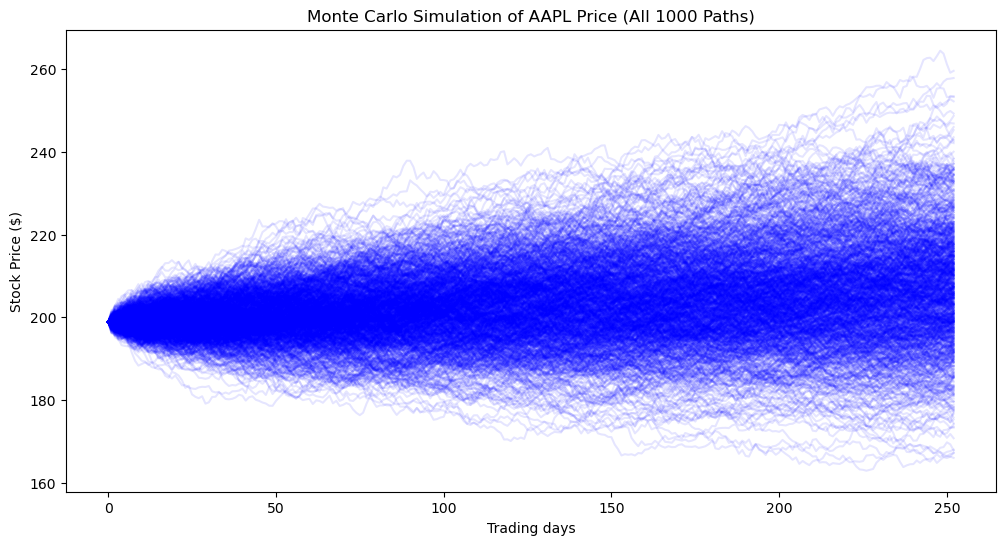

In [111]:
# Plot all 500 simulation paths
plt.figure(figsize=(12, 6))
plt.plot(S.T, color="blue", alpha=0.1)  # Transpose S so each column represents a path

# Formatting
plt.xlabel("Trading days")
plt.ylabel("Stock Price ($)")
plt.title("Monte Carlo Simulation of {} Price (All {} Paths)".format(ticker, num_sims))
plt.show()

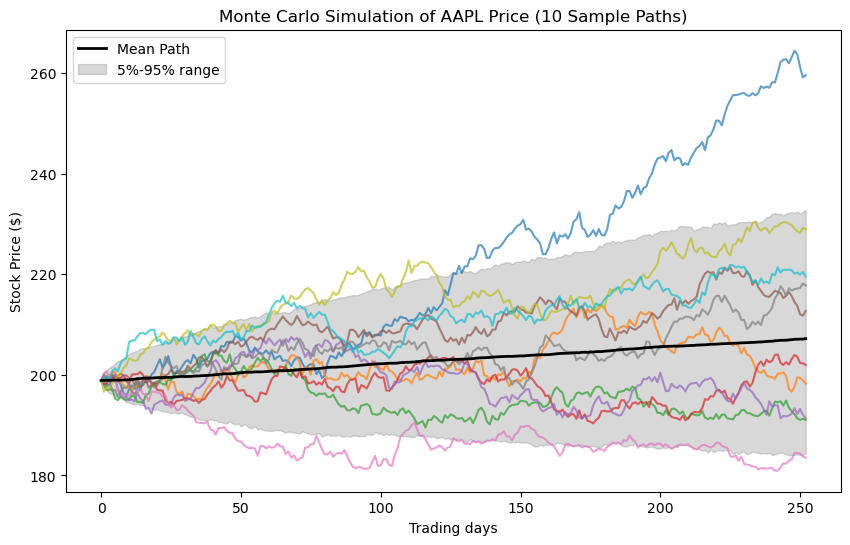

In [112]:
# Plot multiple sample paths
plt.figure(figsize=(10, 6))
for i in range(10):  # Plot only 10 paths for clarity
    plt.plot(S[i, :], alpha=0.7)

# Plot mean and confidence bands
mean_path = np.mean(S, axis=0)
percentile_5 = np.percentile(S, 5, axis=0)
percentile_95 = np.percentile(S, 95, axis=0)

plt.plot(mean_path, color="black", linewidth=2, label="Mean Path")
plt.fill_between(range(S.shape[1]), percentile_5, percentile_95, color="gray", alpha=0.3, label="5%-95% range")

plt.xlabel("Trading days")
plt.ylabel("Stock Price ($)")
plt.title("Monte Carlo Simulation of {} Price (10 Sample Paths)".format(ticker))
plt.legend()
plt.show()

## Call Option Pricing

In [113]:
strikes = np.linspace(20, 500, 50)
today_date = datetime.today().strftime('%Y-%m-%d')
trading_days = len(pd.bdate_range(start=today_date, end=exp_date))

In [114]:
hes_price_model = OptionPricer(S0, r, kappa, theta, sigma, rho, v0, option_type = 'call', pricer='heston')
heston_call_prices = hes_price_model.price_options(strikes, trading_days)

mc_price_model = OptionPricer(S0, r, kappa, theta, sigma, rho, v0, option_type = 'call', pricer='monte_carlo')
monte_carlo_call_prices = mc_price_model.price_options(strikes, trading_days, S)

bs_price_model = OptionPricer(S0, r, kappa, theta, sigma, rho, v0, option_type = 'call', pricer='black_scholes')
black_scholes_call_prices = bs_price_model.price_options(strikes, trading_days)

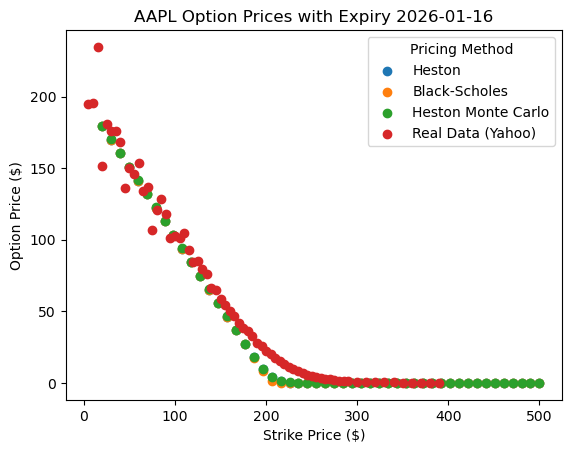

In [115]:
# Plot Option Prices for Heston, Black-Scholes, and Monte Carlo
plt.scatter(strikes, heston_call_prices, label='Heston')
plt.scatter(strikes, black_scholes_call_prices, label='Black-Scholes')
plt.scatter(strikes, monte_carlo_call_prices, label='Heston Monte Carlo')
plt.scatter(df_calls['strike'], df_calls['lastPrice'], label='Real Data (Yahoo)')
plt.xlabel('Strike Price ($)')
plt.ylabel('Option Price ($)')
plt.title('{} Option Prices with Expiry {}'.format(ticker, exp_date))
plt.legend(title="Pricing Method")

## Implied volatility 

In [116]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """
    Calculate Black-Scholes option price
    
    Parameters:
    -----------
    S : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Risk-free interest rate
    sigma : float
        Volatility
    option_type : str
        'call' or 'put'
    
    Returns:
    --------
    float : Option price
    """
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type.lower() == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        
    return price

def implied_volatility(price, S, K, T, r, option_type='call', initial_vol=0.2):
    """
    Calculate implied volatility using Brent's method
    
    Parameters:
    -----------
    price : float
        Market price of the option
    S : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Risk-free interest rate
    option_type : str
        'call' or 'put'
    initial_vol : float
        Initial guess for volatility
    
    Returns:
    --------
    float : Implied volatility
    """
    # Define the objective function (difference between BS price and market price)
    def objective(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - price
    
    try:
        # Use Brent's method to find the implied volatility
        # Reasonable bounds for volatility search: 0.001 to 5.0 (0.1% to 500%)
        implied_vol = brentq(objective, 0.001, 5.0, xtol=1e-8)
        return implied_vol
    except ValueError:
        # If the algorithm fails, it usually means there's no valid implied volatility
        return np.nan
    
def calculate_implied_volatilities(option_prices,S0, K_array, T, r, option_type='call'):
    """
    Calculate implied volatilities for a range of option prices and strikes
    
    Parameters:
    -----------
    option_prices : array-like
        Array of option prices
    S0 : float
        Initial stock price
    K_array : array-like
        Array of strike prices
    T : float
        Time to maturity
    r : float
        Risk-free rate
    option_type : str
        'call' or 'put'
    
    Returns:
    --------
    ndarray : Array of implied volatilities
    """
    implied_vols = []
    
    for i, K in enumerate(K_array):
        iv = implied_volatility(option_prices[i], S0, K, T, r, option_type)
        implied_vols.append(iv)
    
    return np.array(implied_vols)

c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [1, 5, 8, 15]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 2, 6, 9, 10, 28, 30, 32, 33, 35, 37, 40, 42, 43, 45, 48, 49]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


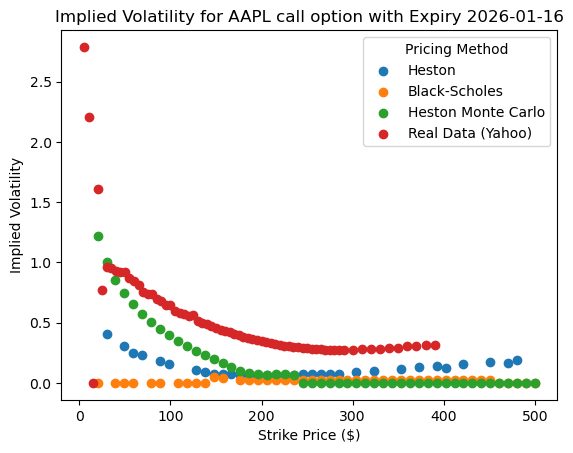

In [117]:
strikes = np.linspace(20, 500, 50)

bs_call_ivs_2 = implied_vol(black_scholes_call_prices,S0, strikes, trading_days/252, r, flag='c',q=0, return_as='numpy')
#bs_call_ivs = calculate_implied_volatilities(black_scholes_call_prices, S0, strikes, T, r, option_type='call')
mc_call_ivs = implied_vol(monte_carlo_call_prices,S0, strikes, trading_days/252, r, flag='c',q=0, return_as='numpy')
#mc_call_ivs = calculate_implied_volatilities(monte_carlo_call_prices, S0, strikes, T, r, option_type='call')
heston_call_ivs = implied_vol(heston_call_prices,S0, strikes, trading_days/252, r, flag='c',q=0, return_as='numpy')

plt.scatter(strikes, heston_call_ivs, label='Heston')
plt.scatter(strikes, bs_call_ivs_2, label='Black-Scholes')
plt.scatter(strikes, mc_call_ivs, label='Heston Monte Carlo')
plt.scatter(df_calls['strike'], df_calls['impliedVolatility'], label='Real Data (Yahoo)')

plt.title('Implied Volatility for {} call option with Expiry {}'.format(ticker,exp_date))
plt.xlabel('Strike Price ($)')
plt.ylabel('Implied Volatility')
plt.legend(title="Pricing Method")
plt.show()

### Volatility Surface for call options priced using Heston Monte Carlo

c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 

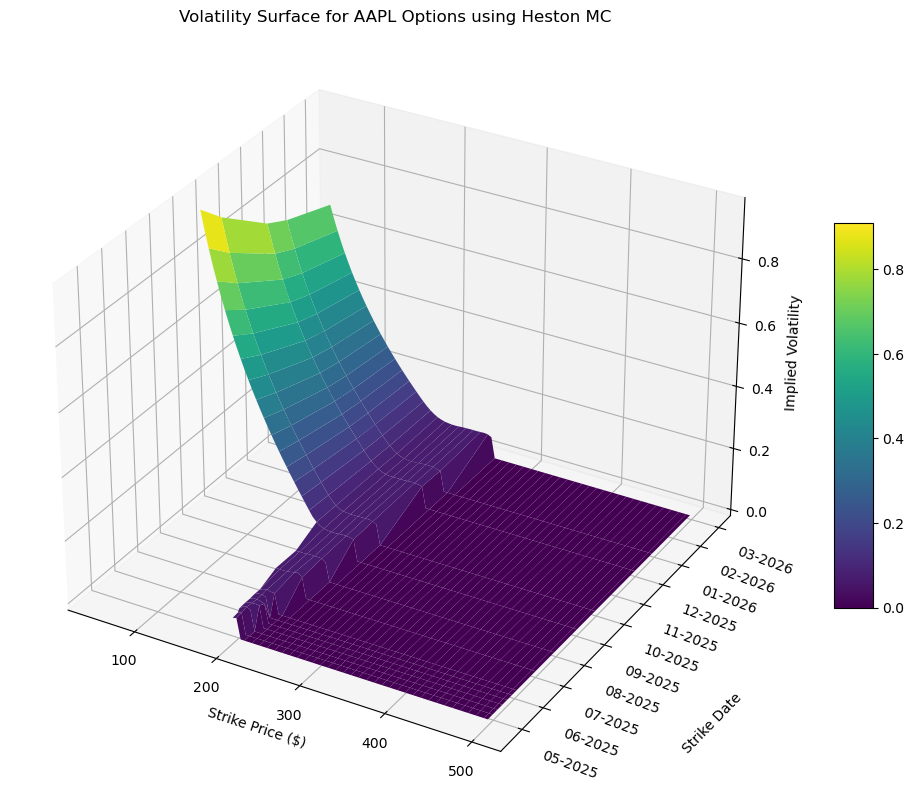

In [118]:
today_date = datetime.today().strftime('%Y-%m-%d')
#dict of strike dates to trading days from today's date
strike_date_to_trading_days = {s : len(pd.bdate_range(start=today_date, end=s)) for s in strike_dates}
#Remove strike dates where the trading days are outside the range of MC simulation
strike_date_to_trading_days = {k: v for k, v in strike_date_to_trading_days.items() if v <= N}

strikes = np.linspace(50, 500, 100)

mc_call_ivs_list = []

for strike_date,trading_days in strike_date_to_trading_days.items():
   
    MC_call_prices = mc_price_model.price_options(strikes, trading_days, S)
    mc_call_ivs = implied_vol(MC_call_prices,S0, strikes, trading_days/252, r, flag='c',q=0, return_as='numpy')
    mc_call_ivs_list.append(mc_call_ivs)
    

# Convert expiry dates to numerical format
strike_dates_num = date2num(list(strike_date_to_trading_days.keys()))

# Create a meshgrid for the expiry dates (y) and strikes (x)
Y, X = np.meshgrid(strike_dates_num, strikes, indexing='ij')
Z = np.array(mc_call_ivs_list)

# Plot the surface
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Format the Y-axis as dates
ax.yaxis.set_major_formatter(DateFormatter('%m-%Y'))
ax.yaxis.set_major_locator(DayLocator(interval=31))  # Adjust the interval for dates

# Rotate date labels for readability
plt.setp(ax.get_yticklabels(), rotation=45, fontsize=10, ha='right')

# Add labels and title
ax.set_xlabel('Strike Price ($)')
ax.set_ylabel('Strike Date', labelpad=40)
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface for {} Options using Heston MC'.format(ticker))

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.setp(ax.get_yticklabels(), rotation=-20, ha='left')

# Show the plot
plt.show()

### Volatility Surface for call options priced using Heston pricing method (semi-analytical formula)

c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 3, 6, 9, 12, 13, 16, 17, 20, 21, 24, 25, 28, 29, 30, 33, 34, 38, 39, 40, 43, 44, 45, 49, 50, 51, 55, 56, 57, 61, 62, 63, 64, 68, 69, 70, 71, 75, 76, 77, 78, 83, 84, 85, 86, 91, 92, 93, 94, 95, 100, 101, 102, 103, 104, 109, 110, 111, 112, 113, 119, 120, 121, 122, 123, 130, 134, 135, 141, 142, 143, 144, 145, 146, 153, 154, 155, 156, 157, 158, 159, 166, 167, 168, 169, 170, 171, 172, 180, 181, 182, 183, 184, 185, 186, 194, 195, 196, 197, 198, 199, 200, 201, 210, 211, 212, 213, 214, 215, 216, 217, 226, 227, 228, 229, 230, 231, 232, 233, 234, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 349, 350, 351, 352, 353, 354, 355

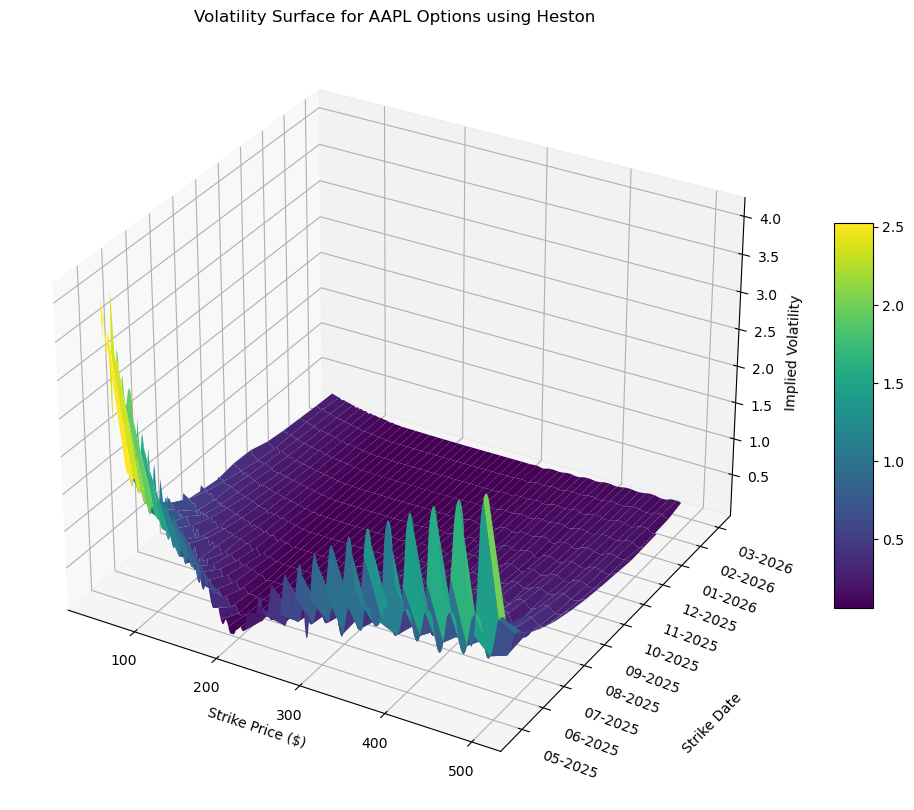

In [ ]:


strikes = np.linspace(50, 500, 400)

heston_call_ivs_list = []

for strike_date,trading_days in strike_date_to_trading_days.items():
   
    heston_call_prices = hes_price_model.price_options(strikes, trading_days)
    heston_call_ivs = implied_vol(heston_call_prices,S0, strikes, trading_days/252, r, flag='c',q=0, return_as='numpy')
    heston_call_ivs_list.append(heston_call_ivs)
    

# Convert expiry dates to numerical format
strike_dates_num = date2num(list(strike_date_to_trading_days.keys()))

# Create a meshgrid for the expiry dates (y) and strikes (x)
Y, X = np.meshgrid(strike_dates_num, strikes, indexing='ij')
Z = np.array(heston_call_ivs_list)


# Interpolation

# Flatten the arrays
x = X.flatten()
y = Y.flatten()
z = Z.flatten()

# Remove NaNs (invalid IVs)
mask = ~np.isnan(z)
x_valid = x[mask]
y_valid = y[mask]
z_valid = z[mask]
# Define the grid we want to interpolate on
xi = np.linspace(X.min(), X.max(), X.shape[1])
yi = np.linspace(Y.min(), Y.max(), Y.shape[0])
XI, YI = np.meshgrid(xi, yi)
ZI = griddata((x_valid, y_valid), z_valid, (XI, YI), method='cubic')

X,Y,Z = XI, YI, ZI

# Plot the surface
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Format the Y-axis as dates
ax.yaxis.set_major_formatter(DateFormatter('%m-%Y'))
ax.yaxis.set_major_locator(DayLocator(interval=31))  # Adjust the interval for dates

# Rotate date labels for readability
plt.setp(ax.get_yticklabels(), rotation=45, fontsize=10, ha='right')

# Add labels and title
ax.set_xlabel('Strike Price ($)')
ax.set_ylabel('Strike Date', labelpad=40)
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface for {} Options using Heston'.format(ticker))

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.setp(ax.get_yticklabels(), rotation=-20, ha='left')

# Show the plot
plt.show()

### Volatility Surface with real option data from Yahoo Finance

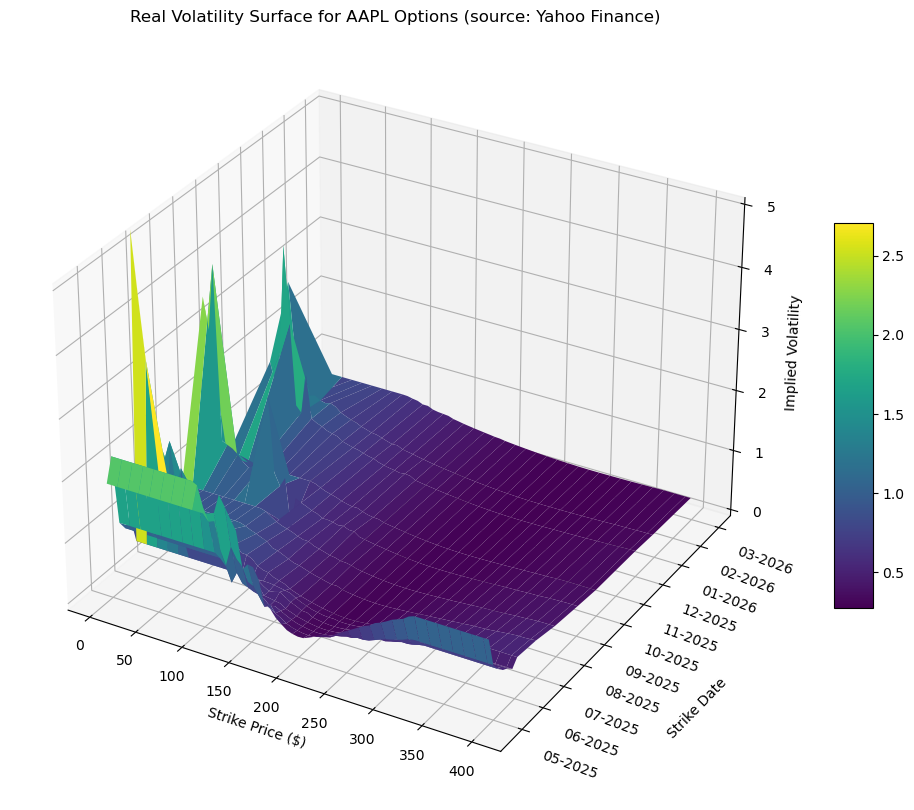

In [144]:
yf_call_ivs_list = []
yf_strike_prices = []

for strike_date,trading_days in strike_date_to_trading_days.items():
    df_calls, df_puts, _ = yfticker.option_chain(strike_date)
    yf_strike_prices.append(df_calls['strike'].tolist())
    yf_call_ivs_list.append(df_calls['impliedVolatility'].tolist())

# Convert expiry dates to numerical format
strike_dates_num = date2num(list(strike_date_to_trading_days.keys()))

# 1. Create uniform x-grid (strike prices)
max_len = max(len(xi) for xi in yf_strike_prices)
x_uniform = np.linspace(min(min(xi) for xi in yf_strike_prices), max(max(xi) for xi in yf_strike_prices), max_len)

# 2. Interpolate z values to x_uniform
z_interp = np.array([np.interp(x_uniform, xi, zi) for xi, zi in zip(yf_strike_prices, yf_call_ivs_list)])


# Create a meshgrid for the expiry dates (y) and strikes (x)
Y, X = np.meshgrid(strike_dates_num, x_uniform, indexing='ij')
Z = z_interp

# Plot the surface
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Format the Y-axis as dates
ax.yaxis.set_major_formatter(DateFormatter('%m-%Y'))
ax.yaxis.set_major_locator(DayLocator(interval=31))  # Adjust the interval for dates

# Rotate date labels for readability
plt.setp(ax.get_yticklabels(), rotation=30, ha='right')

# Add labels and title
ax.set_xlabel('Strike Price ($)')
ax.set_ylabel('Strike Date', labelpad=30)
ax.set_zlabel('Implied Volatility')
ax.set_title('Real Volatility Surface for {} Options (source: Yahoo Finance)'.format(ticker))

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.setp(ax.get_yticklabels(), rotation=-20, ha='left')

# Set the z-axis limits (implied volatility between 0 and 4)
ax.set_zlim([0, 5])

# Show the plot
plt.show()
    

### Volatility Smiles

##### In this section, we check for volatility smiles of a call option with 1 year to expiration over a range of strikes from three option pricing techniques: 1. Heston Model, 2. Heston Model with Monte Carlo, 3. Black Scholes Model

In [122]:
# Pick a strike date from the list of strike dates of the option chain
trading_days = len(pd.bdate_range(start=today_date, end=strike_dates[13])) 


In [123]:
T = trading_days/252  # Convert trading days to years
#trading_days = 252
strikes = np.linspace(20, 500, 50)

sigma = results['parameters']['sigma']
theta = results['parameters']['theta']
v0 = df['rolling_vol'].mean()
kappa = results['parameters']['k']
rho = results['parameters']['rho']
r = np.log(1+df_treasury['3M'].values[-1]/100)

c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 4, 8, 10, 31, 33, 35, 37, 38, 40, 42, 43, 45, 46, 48, 49]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


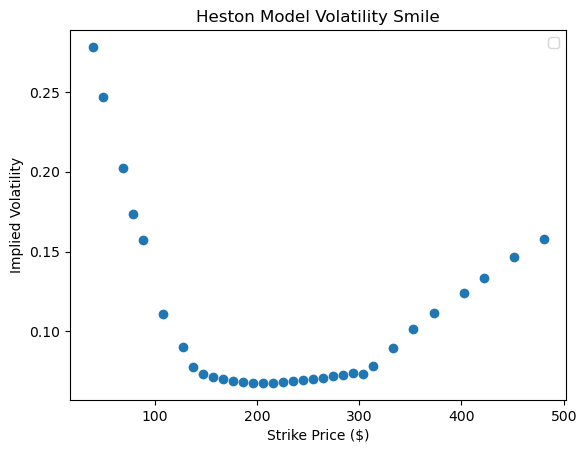

In [124]:
# Volatility smile for Heston model pricing

price_model = OptionPricer(S0, r, kappa, theta, sigma, rho, v0, option_type = 'call', pricer='heston')
heston_call_prices = price_model.price_options(strikes, trading_days)

#puts = np.array([heston_option_price(S0, K, T, r, kappa, theta, sigma, rho, v0) for K in strikes])
call_ivs = implied_vol(heston_call_prices, S0, strikes, T, r, flag='c',q=0, return_as='numpy')
#puts_ivs = implied_vol(puts,S0, strikes, T, r, flag='p',q=0, return_as='numpy')

plt.scatter(strikes, call_ivs)
#plt.plot(strikes, puts_ivs, 'b-', label='Puts')
plt.xlabel('Strike Price ($)')
plt.ylabel('Implied Volatility')
plt.title('Heston Model Volatility Smile')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


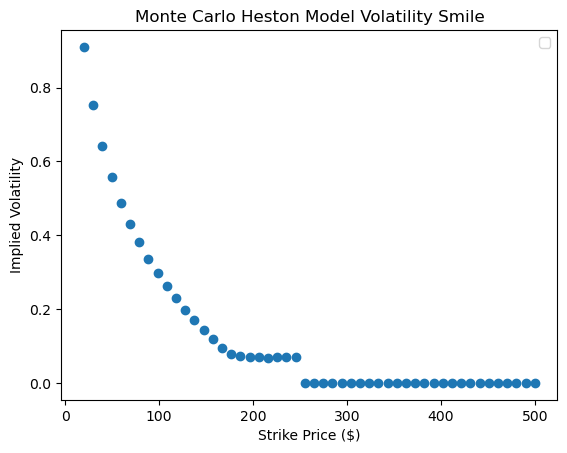

In [125]:
# Volatility smile for Monte Carlo Heston model pricing

model = HestonModel(S0, r, kappa, theta, sigma, rho, v0)
S, V = model.heston_monte_carlo(T, N=trading_days, mu=r, num_sims=1000)

price_model = OptionPricer(S0, r, kappa, theta, sigma, rho, v0, option_type = 'call', pricer='monte_carlo')
mc_heston_call_prices = price_model.price_options(strikes, trading_days, S)

#puts = np.array([heston_option_price(S0, K, T, r, kappa, theta, sigma, rho, v0) for K in strikes])
mc_call_ivs = implied_vol(mc_heston_call_prices, S0, strikes, T, r, flag='c',q=0, return_as='numpy')
#puts_ivs = implied_vol(puts,S0, strikes, T, r, flag='p',q=0, return_as='numpy')

plt.scatter(strikes, mc_call_ivs)
#plt.plot(strikes, puts_ivs, 'b-', label='Puts')
plt.xlabel('Strike Price ($)')
plt.ylabel('Implied Volatility')
plt.title('Monte Carlo Heston Model Volatility Smile')
plt.legend()

c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [9, 10, 11]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


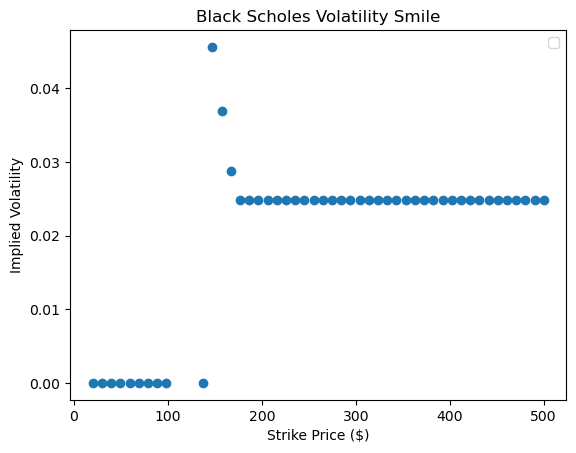

In [126]:
# volatility smile for Black-Scholes model


price_model = OptionPricer(S0, r, kappa, theta, sigma, rho, v0, option_type = 'call', pricer='black_scholes')
heston_call_prices = price_model.price_options(strikes, trading_days)

#puts = np.array([heston_option_price(S0, K, T, r, kappa, theta, sigma, rho, v0) for K in strikes])
bs_call_ivs = implied_vol(heston_call_prices, S0, strikes, T, r, flag='c',q=0, return_as='numpy')
#puts_ivs = implied_vol(puts,S0, strikes, T, r, flag='p',q=0, return_as='numpy')

plt.scatter(strikes, bs_call_ivs)
#plt.plot(strikes, puts_ivs, 'b-', label='Puts')
plt.xlabel('Strike Price ($)')
plt.ylabel('Implied Volatility')
plt.title('Black Scholes Volatility Smile')
plt.legend()

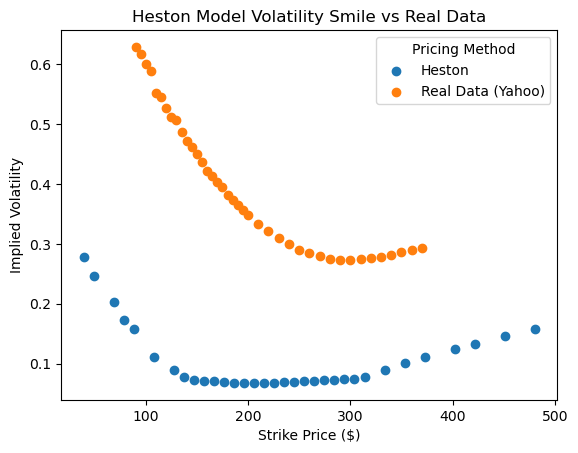

In [127]:
df_calls, df_puts, _ = yfticker.option_chain(strike_dates[13])
plt.scatter(strikes, call_ivs, label='Heston')
plt.scatter(df_calls['strike'], df_calls['impliedVolatility'], label='Real Data (Yahoo)')
plt.xlabel('Strike Price ($)')
plt.ylabel('Implied Volatility')
plt.title('Heston Model Volatility Smile vs Real Data')
plt.legend(title="Pricing Method")